In [6]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [9]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [43]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('LOB/Train_Dst_NoAuction_DecPre_CF_7.txt')
# dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
# dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('LOB/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('LOB/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('LOB/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

dec_train_full = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val_full = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

# Reduce the size of training and validation data to a quarter
dec_train = dec_train_full[:, :int(np.floor(dec_train_full.shape[1] * 0.10))]
dec_val = dec_val_full[:, :int(np.floor(dec_val_full.shape[1] * 0.10))]

# Combine test datasets and reduce to a quarter
dec_test_full = np.hstack((dec_test1, dec_test2, dec_test3))
dec_test = dec_test_full[:, :int(np.floor(dec_test_full.shape[1] * 0.10))]

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 20380) (149, 5095) (149, 13958)


In [44]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([20281, 1, 100, 40]) torch.Size([20281])


In [45]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.2654, 0.0096, 0.2640,  ..., 0.0117, 0.2615, 0.0140],
          [0.2654, 0.0066, 0.2640,  ..., 0.0117, 0.2615, 0.0140],
          [0.2653, 0.0030, 0.2640,  ..., 0.0110, 0.2621, 0.0128],
          ...,
          [0.2653, 0.0004, 0.2642,  ..., 0.0117, 0.2624, 0.0010],
          [0.2653, 0.0004, 0.2646,  ..., 0.0117, 0.2629, 0.0034],
          [0.2653, 0.0004, 0.2644,  ..., 0.0129, 0.2629, 0.0034]]]],
       dtype=torch.float64)
tensor([0.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [46]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [47]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [48]:
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [50]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [51]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▊                                        | 1/50 [05:30<4:29:41, 330.23s/it]

model saved
Epoch 1/50, Train Loss: 1.0121,           Validation Loss: 1.1290, Duration: 0:05:30.221754, Best Val Epoch: 0


  4%|█▋                                       | 2/50 [10:27<4:08:46, 310.97s/it]

Epoch 2/50, Train Loss: 0.8740,           Validation Loss: 1.1573, Duration: 0:04:57.481485, Best Val Epoch: 0


  6%|██▍                                      | 3/50 [15:33<4:01:48, 308.70s/it]

Epoch 3/50, Train Loss: 0.8088,           Validation Loss: 1.1630, Duration: 0:05:05.995669, Best Val Epoch: 0


  8%|███▎                                     | 4/50 [21:35<4:12:36, 329.49s/it]

Epoch 4/50, Train Loss: 0.7750,           Validation Loss: 1.1630, Duration: 0:06:01.339970, Best Val Epoch: 0


 10%|████                                     | 5/50 [27:21<4:11:37, 335.51s/it]

Epoch 5/50, Train Loss: 0.7575,           Validation Loss: 1.1648, Duration: 0:05:46.168239, Best Val Epoch: 0


 12%|████▉                                    | 6/50 [33:16<4:11:03, 342.34s/it]

Epoch 6/50, Train Loss: 0.7407,           Validation Loss: 1.1578, Duration: 0:05:55.591809, Best Val Epoch: 0


 14%|█████▋                                   | 7/50 [38:25<3:57:33, 331.48s/it]

Epoch 7/50, Train Loss: 0.7293,           Validation Loss: 1.1659, Duration: 0:05:09.097151, Best Val Epoch: 0


 16%|██████▌                                  | 8/50 [41:57<3:25:16, 293.25s/it]

Epoch 8/50, Train Loss: 0.7234,           Validation Loss: 1.1582, Duration: 0:03:31.369436, Best Val Epoch: 0


 18%|███████▍                                 | 9/50 [45:30<3:03:11, 268.07s/it]

Epoch 9/50, Train Loss: 0.7159,           Validation Loss: 1.1462, Duration: 0:03:32.717541, Best Val Epoch: 0


 20%|████████                                | 10/50 [48:53<2:45:30, 248.26s/it]

Epoch 10/50, Train Loss: 0.7110,           Validation Loss: 1.1592, Duration: 0:03:23.875433, Best Val Epoch: 0


 22%|████████▊                               | 11/50 [52:16<2:32:13, 234.19s/it]

Epoch 11/50, Train Loss: 0.7061,           Validation Loss: 1.2248, Duration: 0:03:22.293314, Best Val Epoch: 0


 24%|█████████▌                              | 12/50 [55:43<2:23:08, 226.03s/it]

Epoch 12/50, Train Loss: 0.7024,           Validation Loss: 1.1537, Duration: 0:03:27.353828, Best Val Epoch: 0


 26%|██████████▍                             | 13/50 [59:13<2:16:16, 220.98s/it]

Epoch 13/50, Train Loss: 0.6947,           Validation Loss: 1.1388, Duration: 0:03:29.380812, Best Val Epoch: 0


 28%|██████████▋                           | 14/50 [1:03:22<2:17:44, 229.57s/it]

Epoch 14/50, Train Loss: 0.6939,           Validation Loss: 1.1637, Duration: 0:04:09.413971, Best Val Epoch: 0


 30%|███████████▍                          | 15/50 [1:06:52<2:10:32, 223.78s/it]

Epoch 15/50, Train Loss: 0.6925,           Validation Loss: 1.1513, Duration: 0:03:30.346897, Best Val Epoch: 0


 32%|████████████▏                         | 16/50 [1:10:20<2:04:07, 219.05s/it]

Epoch 16/50, Train Loss: 0.6865,           Validation Loss: 1.1634, Duration: 0:03:28.056416, Best Val Epoch: 0


 34%|████████████▉                         | 17/50 [1:13:49<1:58:50, 216.07s/it]

Epoch 17/50, Train Loss: 0.6803,           Validation Loss: 1.1373, Duration: 0:03:29.139355, Best Val Epoch: 0


 36%|█████████████▋                        | 18/50 [1:17:22<1:54:39, 215.00s/it]

Epoch 18/50, Train Loss: 0.6803,           Validation Loss: 1.1537, Duration: 0:03:32.504887, Best Val Epoch: 0


 38%|██████████████▍                       | 19/50 [1:20:58<1:51:14, 215.30s/it]

Epoch 19/50, Train Loss: 0.6794,           Validation Loss: 1.1584, Duration: 0:03:35.994671, Best Val Epoch: 0


 40%|███████████████▏                      | 20/50 [1:24:26<1:46:30, 213.03s/it]

Epoch 20/50, Train Loss: 0.6793,           Validation Loss: 1.1647, Duration: 0:03:27.732993, Best Val Epoch: 0


 42%|███████████████▉                      | 21/50 [1:27:55<1:42:20, 211.76s/it]

Epoch 21/50, Train Loss: 0.6743,           Validation Loss: 1.1589, Duration: 0:03:28.797088, Best Val Epoch: 0


 44%|████████████████▋                     | 22/50 [1:31:47<1:41:42, 217.94s/it]

Epoch 22/50, Train Loss: 0.6732,           Validation Loss: 1.1692, Duration: 0:03:52.342204, Best Val Epoch: 0


 46%|█████████████████▍                    | 23/50 [1:36:00<1:42:46, 228.38s/it]

Epoch 23/50, Train Loss: 0.6710,           Validation Loss: 1.3200, Duration: 0:04:12.725642, Best Val Epoch: 0


 48%|██████████████████▏                   | 24/50 [1:40:17<1:42:47, 237.20s/it]

Epoch 24/50, Train Loss: 0.6671,           Validation Loss: 1.1417, Duration: 0:04:17.759718, Best Val Epoch: 0


 50%|███████████████████                   | 25/50 [1:44:28<1:40:32, 241.29s/it]

Epoch 25/50, Train Loss: 0.6654,           Validation Loss: 1.1631, Duration: 0:04:10.826505, Best Val Epoch: 0


 52%|███████████████████▊                  | 26/50 [1:48:54<1:39:25, 248.57s/it]

Epoch 26/50, Train Loss: 0.6644,           Validation Loss: 1.3210, Duration: 0:04:25.554812, Best Val Epoch: 0


 54%|████████████████████▌                 | 27/50 [1:53:22<1:37:34, 254.53s/it]

Epoch 27/50, Train Loss: 0.6632,           Validation Loss: 1.1692, Duration: 0:04:28.447045, Best Val Epoch: 0


 56%|█████████████████████▎                | 28/50 [1:57:28<1:32:23, 251.97s/it]

Epoch 28/50, Train Loss: 0.6632,           Validation Loss: 1.2363, Duration: 0:04:05.993673, Best Val Epoch: 0


 58%|██████████████████████                | 29/50 [2:01:32<1:27:18, 249.47s/it]

Epoch 29/50, Train Loss: 0.6613,           Validation Loss: 1.1653, Duration: 0:04:03.616744, Best Val Epoch: 0


 60%|██████████████████████▊               | 30/50 [2:05:18<1:20:46, 242.34s/it]

Epoch 30/50, Train Loss: 0.6579,           Validation Loss: 1.1573, Duration: 0:03:45.713452, Best Val Epoch: 0


 62%|███████████████████████▌              | 31/50 [2:08:55<1:14:24, 234.96s/it]

Epoch 31/50, Train Loss: 0.6582,           Validation Loss: 1.1691, Duration: 0:03:37.739222, Best Val Epoch: 0


 64%|████████████████████████▎             | 32/50 [2:12:32<1:08:51, 229.53s/it]

Epoch 32/50, Train Loss: 0.6561,           Validation Loss: 1.1551, Duration: 0:03:36.874041, Best Val Epoch: 0


 66%|█████████████████████████             | 33/50 [2:16:09<1:03:58, 225.82s/it]

Epoch 33/50, Train Loss: 0.6531,           Validation Loss: 1.1693, Duration: 0:03:37.134749, Best Val Epoch: 0


 68%|█████████████████████████▊            | 34/50 [2:20:12<1:01:31, 230.74s/it]

Epoch 34/50, Train Loss: 0.6531,           Validation Loss: 1.1644, Duration: 0:04:02.229284, Best Val Epoch: 0


 70%|████████████████████████████            | 35/50 [2:24:00<57:32, 230.14s/it]

Epoch 35/50, Train Loss: 0.6529,           Validation Loss: 1.1693, Duration: 0:03:48.752829, Best Val Epoch: 0


 72%|████████████████████████████▊           | 36/50 [2:27:28<52:06, 223.36s/it]

Epoch 36/50, Train Loss: 0.6514,           Validation Loss: 1.1693, Duration: 0:03:27.502993, Best Val Epoch: 0


 74%|█████████████████████████████▌          | 37/50 [2:31:06<48:04, 221.85s/it]

Epoch 37/50, Train Loss: 0.6546,           Validation Loss: 1.1693, Duration: 0:03:38.328404, Best Val Epoch: 0


 76%|██████████████████████████████▍         | 38/50 [2:34:44<44:08, 220.71s/it]

Epoch 38/50, Train Loss: 0.6528,           Validation Loss: 1.1693, Duration: 0:03:38.047933, Best Val Epoch: 0


 78%|███████████████████████████████▏        | 39/50 [2:38:29<40:42, 222.02s/it]

Epoch 39/50, Train Loss: 0.6525,           Validation Loss: 1.1693, Duration: 0:03:45.068118, Best Val Epoch: 0


 80%|████████████████████████████████        | 40/50 [2:42:13<37:05, 222.56s/it]

Epoch 40/50, Train Loss: 0.6497,           Validation Loss: 1.1693, Duration: 0:03:43.812662, Best Val Epoch: 0


 82%|████████████████████████████████▊       | 41/50 [2:46:08<33:56, 226.23s/it]

Epoch 41/50, Train Loss: 0.6463,           Validation Loss: 1.1693, Duration: 0:03:54.793679, Best Val Epoch: 0


 84%|█████████████████████████████████▌      | 42/50 [2:49:50<29:59, 224.96s/it]

Epoch 42/50, Train Loss: 0.6453,           Validation Loss: 1.1693, Duration: 0:03:41.987640, Best Val Epoch: 0


 86%|██████████████████████████████████▍     | 43/50 [2:53:27<25:59, 222.76s/it]

Epoch 43/50, Train Loss: 0.6436,           Validation Loss: 1.1693, Duration: 0:03:37.644690, Best Val Epoch: 0


 88%|███████████████████████████████████▏    | 44/50 [2:57:02<22:01, 220.30s/it]

Epoch 44/50, Train Loss: 0.6444,           Validation Loss: 1.1693, Duration: 0:03:34.554846, Best Val Epoch: 0


 90%|████████████████████████████████████    | 45/50 [3:00:34<18:09, 217.94s/it]

Epoch 45/50, Train Loss: 0.6440,           Validation Loss: 1.1693, Duration: 0:03:32.428837, Best Val Epoch: 0


 92%|████████████████████████████████████▊   | 46/50 [3:04:04<14:21, 215.31s/it]

Epoch 46/50, Train Loss: 0.6425,           Validation Loss: 1.1693, Duration: 0:03:29.157673, Best Val Epoch: 0


 94%|█████████████████████████████████████▌  | 47/50 [3:07:36<10:42, 214.33s/it]

Epoch 47/50, Train Loss: 0.6435,           Validation Loss: 1.1693, Duration: 0:03:32.043093, Best Val Epoch: 0


 96%|██████████████████████████████████████▍ | 48/50 [3:11:05<07:05, 212.81s/it]

Epoch 48/50, Train Loss: 0.6402,           Validation Loss: 1.1693, Duration: 0:03:29.255066, Best Val Epoch: 0


 98%|███████████████████████████████████████▏| 49/50 [3:14:35<03:31, 211.97s/it]

Epoch 49/50, Train Loss: 0.6431,           Validation Loss: 1.1693, Duration: 0:03:30.027795, Best Val Epoch: 0


100%|████████████████████████████████████████| 50/50 [3:18:31<00:00, 238.24s/it]

Epoch 50/50, Train Loss: 0.6419,           Validation Loss: 1.1693, Duration: 0:03:56.294640, Best Val Epoch: 0


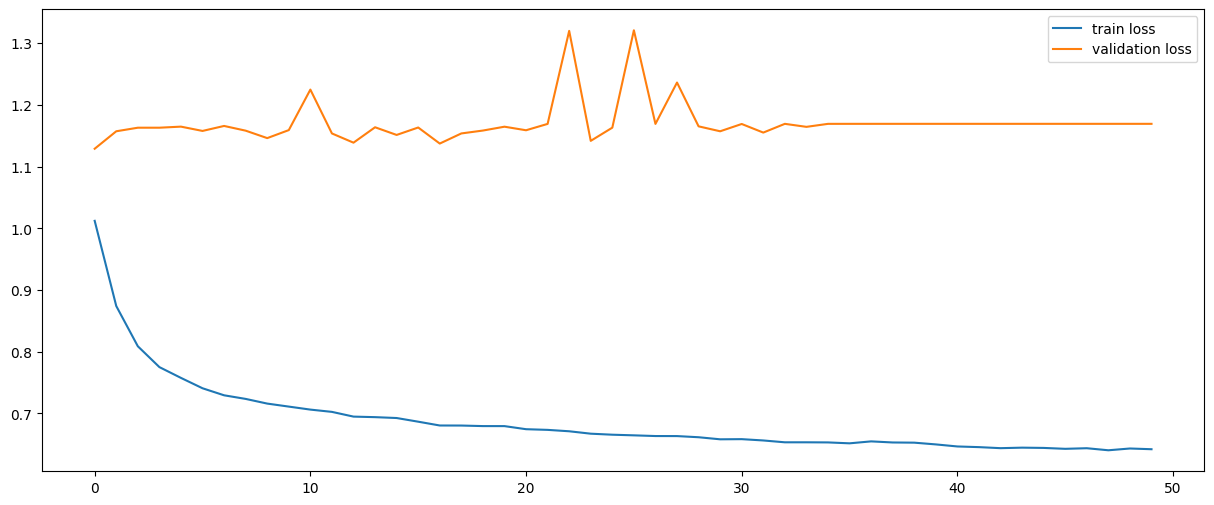

In [52]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [53]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.4062


In [54]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

In [55]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.4061620607547442
              precision    recall  f1-score   support

           0     0.4031    0.6447    0.4961      5685
           1     0.0000    0.0000    0.0000      3200
           2     0.4119    0.3949    0.4032      4974

    accuracy                         0.4062     13859
   macro avg     0.2717    0.3465    0.2998     13859
weighted avg     0.3132    0.4062    0.3482     13859



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa